# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

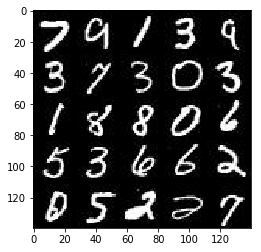

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

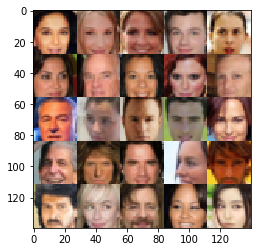

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same',kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
    
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Set channel width
    if data_image_mode == "RGB":
        image_channels = 3
    else:
        image_channels = 1
        
    # Set data shape
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    show_every = 100
    print_every = 10
    steps = 0
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if (steps % print_every == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)) 
                
                if (steps % show_every == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5622... Generator Loss: 1.9592
Epoch 1/2... Discriminator Loss: 2.7533... Generator Loss: 0.1484
Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 3.5620
Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.9296
Epoch 1/2... Discriminator Loss: 1.7527... Generator Loss: 0.5003
Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 0.9839
Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 1.8608
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 4.1279
Epoch 1/2... Discriminator Loss: 0.6422... Generator Loss: 1.9468


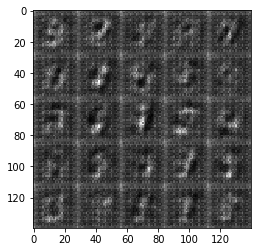

Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 3.6552
Epoch 1/2... Discriminator Loss: 1.4916... Generator Loss: 4.3229
Epoch 1/2... Discriminator Loss: 0.6750... Generator Loss: 1.5469
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 3.0450
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 0.5979
Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 2.7413
Epoch 1/2... Discriminator Loss: 0.5260... Generator Loss: 1.9781
Epoch 1/2... Discriminator Loss: 0.4572... Generator Loss: 2.3815
Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 2.5000
Epoch 1/2... Discriminator Loss: 0.3597... Generator Loss: 4.2020


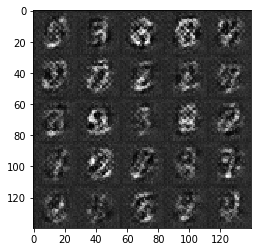

Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 0.9906
Epoch 1/2... Discriminator Loss: 0.6794... Generator Loss: 1.3990
Epoch 1/2... Discriminator Loss: 0.6055... Generator Loss: 1.6318
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 2.8643
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 1.5610
Epoch 1/2... Discriminator Loss: 0.4612... Generator Loss: 2.4721
Epoch 1/2... Discriminator Loss: 0.4704... Generator Loss: 2.5012
Epoch 1/2... Discriminator Loss: 0.4870... Generator Loss: 2.1360
Epoch 1/2... Discriminator Loss: 0.4454... Generator Loss: 2.6549
Epoch 1/2... Discriminator Loss: 0.4304... Generator Loss: 3.1005


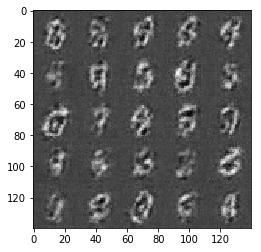

Epoch 1/2... Discriminator Loss: 0.4593... Generator Loss: 2.6049
Epoch 1/2... Discriminator Loss: 0.4452... Generator Loss: 2.5956
Epoch 1/2... Discriminator Loss: 0.4375... Generator Loss: 2.7469
Epoch 1/2... Discriminator Loss: 0.4488... Generator Loss: 2.5933
Epoch 1/2... Discriminator Loss: 0.4285... Generator Loss: 2.8435
Epoch 1/2... Discriminator Loss: 0.5369... Generator Loss: 4.2538
Epoch 1/2... Discriminator Loss: 0.5624... Generator Loss: 2.6918
Epoch 1/2... Discriminator Loss: 0.4622... Generator Loss: 2.4172
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 3.2384
Epoch 1/2... Discriminator Loss: 0.4415... Generator Loss: 2.4916


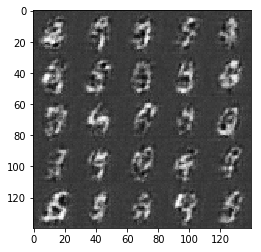

Epoch 1/2... Discriminator Loss: 0.4174... Generator Loss: 2.9329
Epoch 1/2... Discriminator Loss: 0.3981... Generator Loss: 3.1003
Epoch 1/2... Discriminator Loss: 0.4188... Generator Loss: 2.8064
Epoch 1/2... Discriminator Loss: 0.4238... Generator Loss: 2.6652
Epoch 1/2... Discriminator Loss: 0.4133... Generator Loss: 2.8389
Epoch 1/2... Discriminator Loss: 0.4005... Generator Loss: 3.2177
Epoch 2/2... Discriminator Loss: 0.4020... Generator Loss: 3.0506
Epoch 2/2... Discriminator Loss: 0.4312... Generator Loss: 2.6378
Epoch 2/2... Discriminator Loss: 0.4172... Generator Loss: 2.8892
Epoch 2/2... Discriminator Loss: 0.4003... Generator Loss: 2.9728


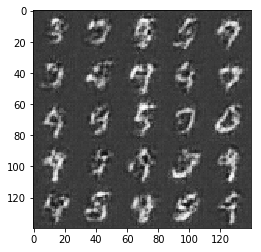

Epoch 2/2... Discriminator Loss: 0.4026... Generator Loss: 3.1088
Epoch 2/2... Discriminator Loss: 0.4141... Generator Loss: 2.8087
Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 3.4779
Epoch 2/2... Discriminator Loss: 0.3885... Generator Loss: 3.4014
Epoch 2/2... Discriminator Loss: 0.3799... Generator Loss: 3.7838
Epoch 2/2... Discriminator Loss: 0.4309... Generator Loss: 2.6711
Epoch 2/2... Discriminator Loss: 0.4777... Generator Loss: 2.7514
Epoch 2/2... Discriminator Loss: 2.6174... Generator Loss: 1.5267
Epoch 2/2... Discriminator Loss: 0.9710... Generator Loss: 1.0021
Epoch 2/2... Discriminator Loss: 0.5814... Generator Loss: 2.3888


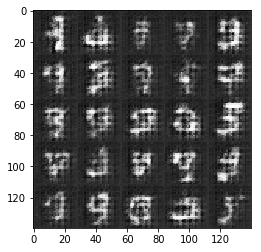

Epoch 2/2... Discriminator Loss: 0.5812... Generator Loss: 1.8164
Epoch 2/2... Discriminator Loss: 0.4520... Generator Loss: 2.9878
Epoch 2/2... Discriminator Loss: 0.4172... Generator Loss: 2.9197
Epoch 2/2... Discriminator Loss: 0.4189... Generator Loss: 2.9060
Epoch 2/2... Discriminator Loss: 0.4005... Generator Loss: 3.4905
Epoch 2/2... Discriminator Loss: 0.3933... Generator Loss: 3.3580
Epoch 2/2... Discriminator Loss: 0.4143... Generator Loss: 2.7888
Epoch 2/2... Discriminator Loss: 0.4086... Generator Loss: 2.8855
Epoch 2/2... Discriminator Loss: 0.4111... Generator Loss: 3.0789
Epoch 2/2... Discriminator Loss: 0.3931... Generator Loss: 3.1536


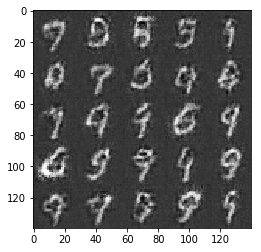

Epoch 2/2... Discriminator Loss: 0.4583... Generator Loss: 2.4322
Epoch 2/2... Discriminator Loss: 0.3952... Generator Loss: 3.4101
Epoch 2/2... Discriminator Loss: 0.3946... Generator Loss: 3.3745
Epoch 2/2... Discriminator Loss: 0.4477... Generator Loss: 2.4315
Epoch 2/2... Discriminator Loss: 0.3798... Generator Loss: 3.5333
Epoch 2/2... Discriminator Loss: 0.3761... Generator Loss: 3.4784
Epoch 2/2... Discriminator Loss: 0.4056... Generator Loss: 3.1587
Epoch 2/2... Discriminator Loss: 0.4161... Generator Loss: 3.2555
Epoch 2/2... Discriminator Loss: 0.3919... Generator Loss: 3.3770
Epoch 2/2... Discriminator Loss: 0.4056... Generator Loss: 3.0830


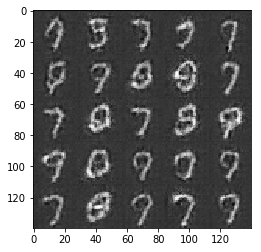

Epoch 2/2... Discriminator Loss: 0.3918... Generator Loss: 4.0874
Epoch 2/2... Discriminator Loss: 0.4473... Generator Loss: 2.4565
Epoch 2/2... Discriminator Loss: 0.4154... Generator Loss: 2.8417
Epoch 2/2... Discriminator Loss: 0.4120... Generator Loss: 3.9029
Epoch 2/2... Discriminator Loss: 2.0270... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 2.0063
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 1.3571
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 1.3922
Epoch 2/2... Discriminator Loss: 0.5316... Generator Loss: 2.2252
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 2.5928


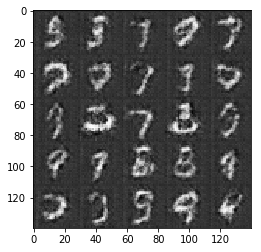

Epoch 2/2... Discriminator Loss: 0.4445... Generator Loss: 2.6456
Epoch 2/2... Discriminator Loss: 0.4774... Generator Loss: 2.3164
Epoch 2/2... Discriminator Loss: 0.4377... Generator Loss: 3.0646


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = .0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.7146
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 2.1997
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.4137
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 2.8394
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 2.7449
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 4.5950
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 2.7454
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 1.9496
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 3.0575


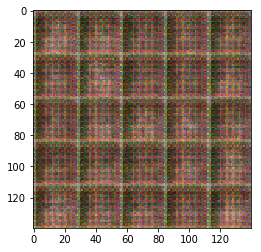

Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 4.6144
Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 2.1810
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 5.7180
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 2.3132
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 3.3351
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 3.4735
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 2.1757
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 4.1668
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 3.7551
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 2.7242


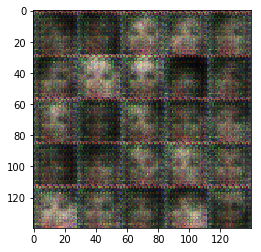

Epoch 1/1... Discriminator Loss: 0.4246... Generator Loss: 3.5893
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 3.4908
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.8729
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 3.2565
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 2.2113
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.6778
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.4632
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 2.6673
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.8449
Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 2.9517


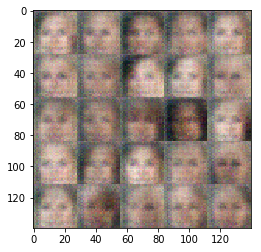

Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 1.9998
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 2.5627
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.4845
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 2.7327
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 2.8088
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 2.9647
Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 2.7694
Epoch 1/1... Discriminator Loss: 0.4471... Generator Loss: 3.1257


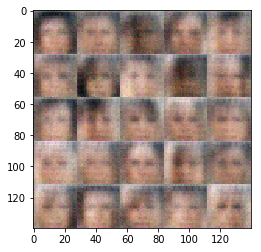

Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 2.0959
Epoch 1/1... Discriminator Loss: 0.4597... Generator Loss: 2.9176
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 2.4631
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 2.4656
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 2.3649
Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 2.2654
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 2.4250
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 2.4764
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 3.4409
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 3.0427


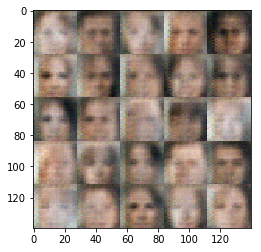

Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 1.8703
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 2.5425
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.9490
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 1.6056
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.7483
Epoch 1/1... Discriminator Loss: 0.6330... Generator Loss: 1.8610
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 2.5093
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 2.0254
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 1.9839


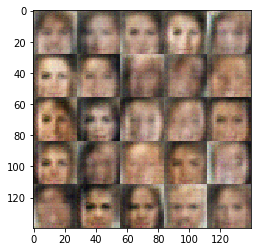

Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 2.6364
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 2.7810
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 3.1369
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 2.9953
Epoch 1/1... Discriminator Loss: 0.5232... Generator Loss: 2.2303
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.3534
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 1.8210
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 2.3373
Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 2.7304


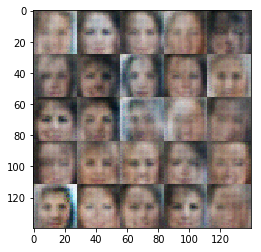

Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 3.2413
Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 1.9378
Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 1.7071
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.4179
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 3.3810
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.2301
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 1.8298
Epoch 1/1... Discriminator Loss: 0.3776... Generator Loss: 4.5620
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 2.3811
Epoch 1/1... Discriminator Loss: 0.4471... Generator Loss: 3.4806


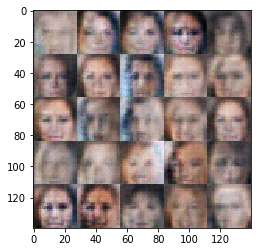

Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 5.3189
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 6.9006
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 2.1297
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 0.3720... Generator Loss: 5.1117
Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 4.8801
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 6.3700
Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 4.1045
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 2.2538
Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 5.6184


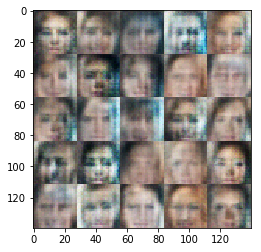

Epoch 1/1... Discriminator Loss: 0.3595... Generator Loss: 5.5712
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 10.4157
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 7.0002
Epoch 1/1... Discriminator Loss: 2.1655... Generator Loss: 0.2656
Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 4.1446
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 6.3700
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 3.5498
Epoch 1/1... Discriminator Loss: 0.3835... Generator Loss: 4.2323
Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 2.6409
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 1.6403


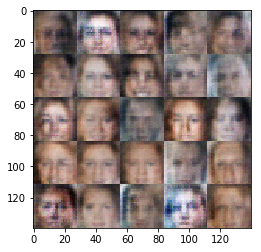

Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 3.9933
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 7.4263
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 8.8140
Epoch 1/1... Discriminator Loss: 0.3617... Generator Loss: 5.7688
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 3.4054
Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 4.7744
Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 4.1161
Epoch 1/1... Discriminator Loss: 0.3798... Generator Loss: 5.3607


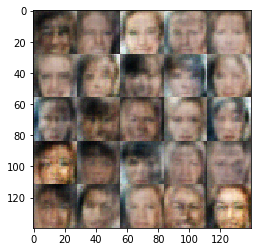

Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 4.5101
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 4.1500
Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 3.9868
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 7.8164
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 5.2562
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 5.2379
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 5.4342
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 2.7075
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 5.4141
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.7960


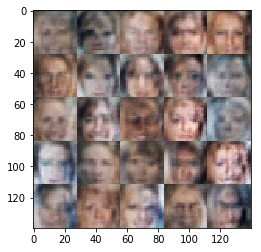

Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 7.0700
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 9.7692
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 4.9990
Epoch 1/1... Discriminator Loss: 0.3841... Generator Loss: 5.6437
Epoch 1/1... Discriminator Loss: 0.3641... Generator Loss: 7.1216
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 6.4132
Epoch 1/1... Discriminator Loss: 0.3495... Generator Loss: 8.3321
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 5.6942
Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 5.1789
Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 7.8069


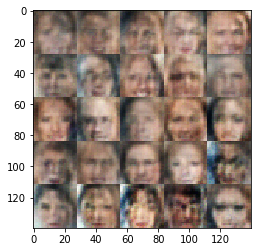

Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.6219
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 6.6631
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 2.9802
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 2.7228
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 4.1438
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 4.6735
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 6.0418
Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 7.5640
Epoch 1/1... Discriminator Loss: 3.6090... Generator Loss: 0.0589
Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 2.5264


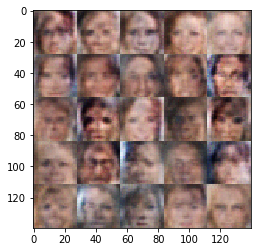

Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 3.9444
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 4.0271
Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 3.8351
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 3.3232
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 4.8191
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 10.0902
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 9.7688
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 3.8777
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 3.5027


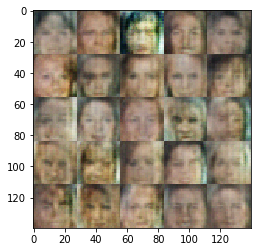

Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.7176
Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 4.3399
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.5607
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 3.2408
Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 2.9644
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 4.1772
Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 4.1251
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 5.5888
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 5.8467
Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 5.5510


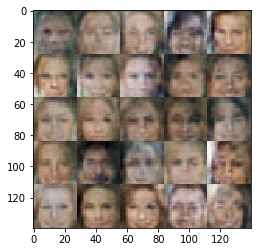

Epoch 1/1... Discriminator Loss: 0.5731... Generator Loss: 12.6959
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.7658
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 5.8776
Epoch 1/1... Discriminator Loss: 0.4725... Generator Loss: 6.5332
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 2.9750
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 3.6734
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 2.7593
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 9.2027
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 9.4706
Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 8.1341


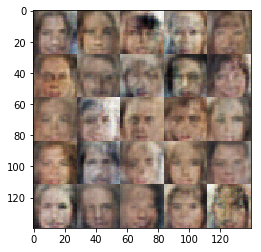

Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 4.6817
Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 5.6378
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 5.9783
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 7.4423
Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 4.0505
Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 5.8838
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 3.2991
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 3.1248
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.6042
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.6669


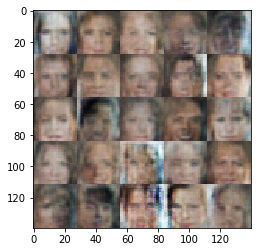

Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 4.8440
Epoch 1/1... Discriminator Loss: 0.3413... Generator Loss: 7.7085
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 6.9735
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 7.4313
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 5.9095
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 5.1834
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.0635
Epoch 1/1... Discriminator Loss: 0.6364... Generator Loss: 10.0213
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 5.6230
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 3.8974


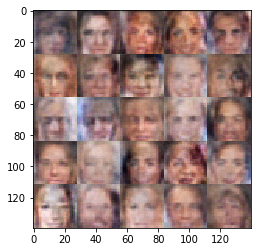

Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 8.4782
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 4.4132
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 9.2905
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 9.6954
Epoch 1/1... Discriminator Loss: 0.4847... Generator Loss: 2.4359
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 4.5264
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 9.8184
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 3.3754
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 2.9735
Epoch 1/1... Discriminator Loss: 0.3517... Generator Loss: 6.7385


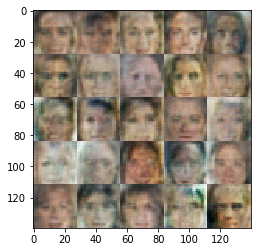

Epoch 1/1... Discriminator Loss: 0.4051... Generator Loss: 3.9809
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 5.6527
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 4.4825
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.4380
Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 7.5629
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 7.9204
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 6.6531
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 6.1039
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 5.8362


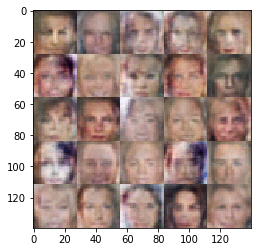

Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 2.3918
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 7.5815
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 2.2992
Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 2.5072
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 2.6515
Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 12.0765
Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 6.2630
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 1.9784
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 6.9433
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.6093


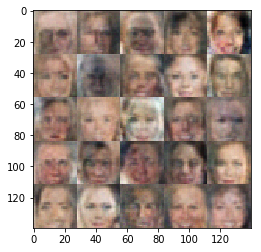

Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.4141
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 1.7527
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 6.0342
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 6.6272
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 2.5621
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 5.6659
Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 8.9316
Epoch 1/1... Discriminator Loss: 0.3636... Generator Loss: 5.1389
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 2.5859
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 4.1029


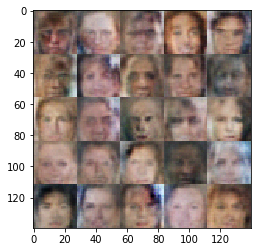

Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 4.9873
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 6.4400
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 6.0753
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 3.8389
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 4.0271
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 2.2482
Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 4.1815
Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 6.1474
Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 4.4387
Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 7.7233


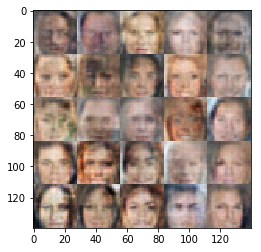

Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 3.5942
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 2.8001
Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 5.4256
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 1.3911
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 4.0323
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.3415
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 6.2752
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 7.5196
Epoch 1/1... Discriminator Loss: 0.3450... Generator Loss: 7.0310
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 5.8199


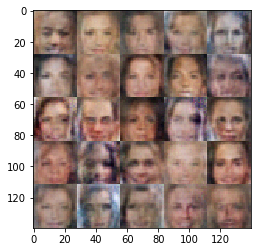

Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 7.1982
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 8.3907
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 10.1701
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 4.5359
Epoch 1/1... Discriminator Loss: 0.3516... Generator Loss: 4.9650
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 5.9427
Epoch 1/1... Discriminator Loss: 0.3661... Generator Loss: 6.3562
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 7.3656
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 0.3617... Generator Loss: 4.5064


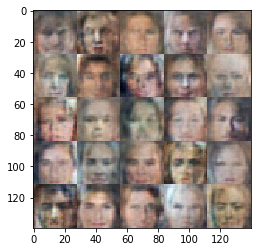

Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 6.4379
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 7.0747
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 7.0008
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 2.1863
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 5.5734
Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 3.9120
Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 1.4083
Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 5.2874
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 5.2934
Epoch 1/1... Discriminator Loss: 0.4729... Generator Loss: 2.3100


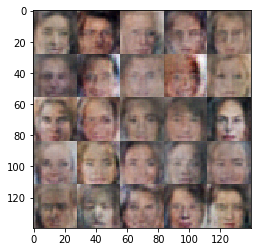

Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 3.6178
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 5.3219
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 2.4290
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 6.5053


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.